<a href="https://colab.research.google.com/github/CarolinaKra/FashionArticlesImageClassification/blob/main/AFashionArticlesImagesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Label Classification of Fashion Articles Images**
## Report Structre
####  Introduction
  1. Problem Definition
  2. Set a measure of success
  3. Set an evaluation protocol

#### Methodology and Partial Results
  4. Data Preparation
    * Loading and exploring the data
    * Data Cleansing
    * Image Processing
    * Continue Preparing the dataset for Neural Network
    * Splitting the data into training, validation and test sets
  5. Develope a model that does better than the baseline
    * Creation of a baseline model by creating a model using dense layer only
    * Building a simple convolutional Neural Network to beat the baseline model
  6. Scaling up: develop to a model that overfits
  7. Tune hyperparameter and add regularizer
    * Tunning hyperparameters for a standard model architecture
    * Adding Batch Normalisation
    * Adding Dropout regulariser
    * Training the final model

#### Final Results
  * Accuracy for each classification task and average accuracy
  * Confusion matrices
  * Ploting test images examples

#### Conclusions


# Introduction
## 1. Problem definition

It is an exciting time for the e-commerce industry.  It is possible to sell and buy articles through a wide range of apps and websites, especially articles for daily use such as clothes and shoes. Many factors affect the success of these apps and websites, including their popularity, security when paying, article prices, and user-friendliness. 

In relation to the last point, a website should be very structured in order to create an environment that enables customers to easily find the article they are looking for.  As there could be multiple sellers on a single website, creating a dataset with all articles sorted according to the same standard may be difficult.

The purpose of this work is to facilitate this task for a newly developed e-commerce platform by developing a computer vision model that can identify different categories of fashion articles such as gender and article type.
 
An already existing structured dataset of fashion articles data and its corresponding images will be utilized in this project.
 Additionally, the universal machine learning workflow will be followed to build the best possible model.

The hypothesis is defined as follow:
* The gender and article type (both for a masterCategory and subCategory) could be predicted from the article image.

## 2. Set a measure of success

The measure of success will be the accuracy, it will be calculated for each classification task, and it will be averaged to measure the overall performance of the model.

## 3. Set an evaluation protocol
We will use fuctional API programming from Tensoflow 2.0 to create a Convolutional Neural Network for multi-label image classification task.
The model will be optimised by finding the best model architecture and hyperparameters. This will be done by training a subset of the data, the "training set", and verifing it with a small subset known as the "validation set". Moreover, the validation will help understand when the model has learnt enough to generalise, while preventing overfitting. The chosen evaluation protocol is "one hold-out" where we train with the training set and evaluate with the validation set once for every epoch.

In the final stage, we will evaluate how well the model was able to generalise by testing the model in an unseen dataset known as the "test set" 


# Methodology and Partial Results
In this part I go through the programming steps of the Universal Machine Learning Workflow and show the partial results obtained at each step


In [1]:
#import relevant libraries and set up
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, Input
import numpy as np
from PIL import Image
import os 
import seaborn as sns
seed_val = 987
np.random.seed(seed_val)

## 4. Data preparation

### Loading and exploring the data

In [2]:
#download the data from Kaggle
# A personal kaggle key is needed to download the content from kaggle 
!pwd
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

/content
 97% 548M/565M [00:03<00:00, 116MB/s] 
100% 565M/565M [00:04<00:00, 146MB/s]


In [3]:
#unzip the data
!unzip -qq fashion-product-images-small.zip -d fashion-products

The data consists in a csv dataset with the information about the pictures and a folder with the product images

In [4]:
#Start by openning the file and exploring the dataset
df=pd.read_csv('fashion-products/myntradataset/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
df.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume
44423,51623,Women,Accessories,Watches,Watches,Pink,Winter,2016.0,Casual,Fossil Women Pink Dial Chronograph Watch ES3050


In [6]:
#verifing the dataset shape (number of rows, number of columns)
df.shape

(44424, 10)

In [7]:
# running many models becomes difficult with such amount of images as it required a huge resources of RAM
#I will work with a sample of the whole dataset containing a third of the dataset
#choosing randomly a third of the dataset indices
num_samples=int(len(df)/3)
indices=np.random.choice(range(len(df)),size=num_samples, replace=False)


In [8]:
#the new dataset will be composed of the previously selected indices
#re-index the dataset
df=df.loc[indices]
df.index=range(len(df))

In [9]:
df.shape

(14808, 10)

In [10]:
#I continue by exploring the different classes in the diferent categories
for column in df.columns[1:-1]:
    print(column+" classes:")
    print(df[column].unique())

gender classes:
['Women' 'Men' 'Unisex' 'Girls' 'Boys']
masterCategory classes:
['Footwear' 'Apparel' 'Accessories' 'Personal Care' 'Sporting Goods'
 'Free Items' 'Home']
subCategory classes:
['Shoes' 'Topwear' 'Bags' 'Eyewear' 'Saree' 'Socks' 'Belts' 'Nails'
 'Loungewear and Nightwear' 'Jewellery' 'Dress' 'Flip Flops' 'Wallets'
 'Watches' 'Bottomwear' 'Sports Equipment' 'Ties' 'Innerwear' 'Skin'
 'Accessories' 'Headwear' 'Fragrance' 'Makeup' 'Sandal' 'Lips' 'Eyes'
 'Scarves' 'Mufflers' 'Free Gifts' 'Apparel Set' 'Skin Care' 'Gloves'
 'Cufflinks' 'Shoe Accessories' 'Bath and Body' 'Home Furnishing'
 'Beauty Accessories' 'Perfumes' 'Stoles' 'Sports Accessories' 'Hair'
 'Umbrellas' 'Water Bottle']
articleType classes:
['Heels' 'Tshirts' 'Handbags' 'Sunglasses' 'Sarees' 'Casual Shoes' 'Socks'
 'Shirts' 'Belts' 'Rain Jacket' 'Formal Shoes' 'Nail Polish' 'Nightdress'
 'Backpacks' 'Kurtas' 'Tops' 'Earrings' 'Dresses' 'Flip Flops' 'Wallets'
 'Watches' 'Jackets' 'Sports Shoes' 'Leggings' 'Bask

The reduced dataframe contains information about 14808 articles, which are categorised in differnt ways, by gender, by masterCategory, by subCategory and more detailed categories such as article type, detail description of the products between others. In addition, each article has an id which matches the name of the image in the images folder. 

The dataset does not contain a specific order, hence there won't be a need for data shuffling.

From looking at the classes in the different column, the gender, masterCategory and subCategory were selected for the image multi-label classification task.

We contine by exploring the the distribution of the different classes within each category.

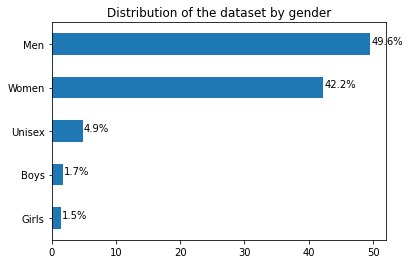

In [11]:
#start with gender
counts_gender=df['gender'].value_counts()/len(df)*100
ax=counts_gender.plot.barh()
ax.set_title('Distribution of the dataset by gender')
ax.invert_yaxis()
for i,value in enumerate(counts_gender):
    ax.annotate(str(round(value,1))+"%", xy=(value+0.15,i))
plt.show()

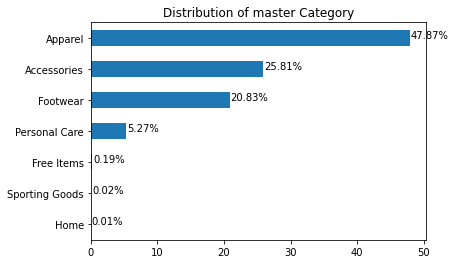

In [12]:
#continue with masterCategory
counts_masterCategory=df['masterCategory'].value_counts()/len(df)*100
ax=counts_masterCategory.plot.barh()
ax.set_title('Distribution of master Category')
ax.invert_yaxis()
for i,value in enumerate(counts_masterCategory):
    ax.annotate(str(round(value,2))+"%", xy=(value+0.15,i))
plt.show()

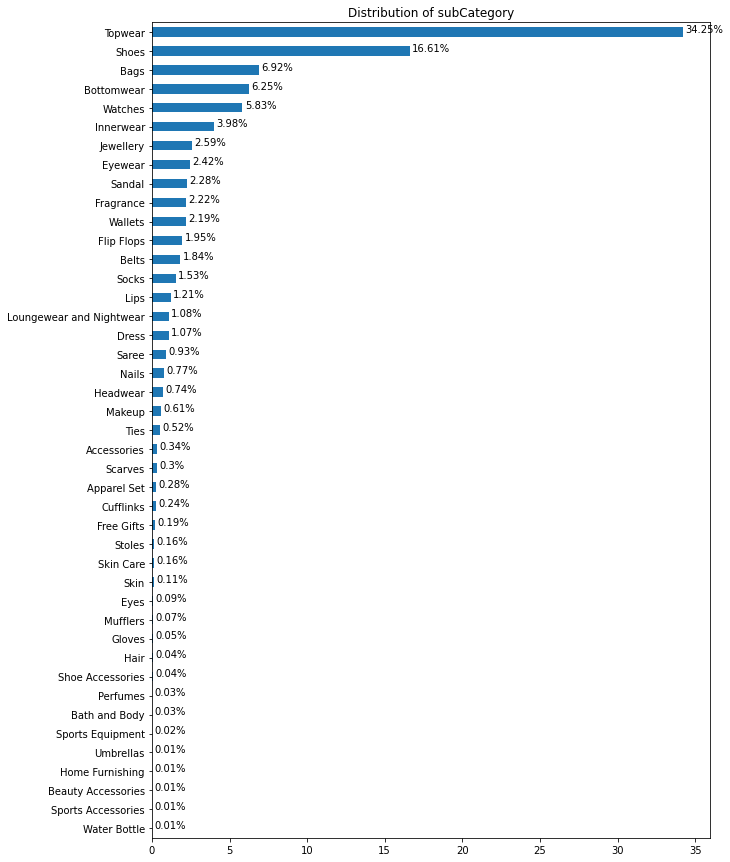

In [13]:
#continue with subCategory
counts_subCategory=df['subCategory'].value_counts()/len(df)*100
plt.figure(figsize=(10,15))
ax=counts_subCategory.plot.barh()
ax.set_title('Distribution of subCategory')
ax.invert_yaxis()
for i,value in enumerate(counts_subCategory):
    ax.annotate(str(round(value,2))+"%", xy=(value+0.15,i))
plt.show()

### Data Cleansing

The dataset contains several classes that are underrepresented because they make up a very small percentage. We will exclude the classes that comprise less than 1% of the dataset to simplify the learning process.

In [14]:
#exclude underrepresented classess in gender
excluded_gender=[counts_gender.index[i] 
                        for i in range(len(counts_gender))
                         if counts_gender.values[i]<1 ]
                         #exclude underrepresented classess in subcategory
excluded_subcategory=[counts_subCategory.index[i] 
                        for i in range(len(counts_subCategory))
                         if counts_subCategory.values[i]<1 ]
                         #exclude underrepresented classess in mastercategory
excluded_mastercategory=[counts_masterCategory.index[i] 
                        for i in range(len(counts_masterCategory))
                         if counts_masterCategory.values[i]<1 ]

In [15]:
#we create a copy of the orginal dataset and start cleaning it from  the underrepresented classes
dfclean=df.copy(deep=True)
for i in range(len(df)):
    if dfclean['masterCategory'][i] in excluded_mastercategory:
        dfclean.drop(i, axis=0, inplace=True)
    else:
        if dfclean['subCategory'][i] in excluded_subcategory:
            dfclean.drop(i, axis=0, inplace=True)
        else:
            if dfclean['gender'][i] in excluded_gender:
                dfclean.drop(i, axis=0, inplace=True)


In [16]:
#I reset the index
dfclean.index=range(len(dfclean))

We will look again at the distributions

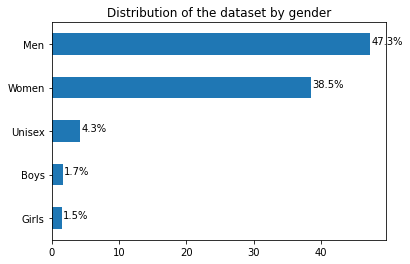

In [108]:
counts_clean_gender=dfclean['gender'].value_counts()/len(df)*100
ax=counts_clean_gender.plot.barh()
ax.set_title('Distribution of the dataset by gender')
ax.invert_yaxis()
for i,value in enumerate(counts_clean_gender):
    ax.annotate(str(round(value,1))+"%", xy=(value+0.15,i))
plt.savefig('genderDistribution.png')
plt.show()

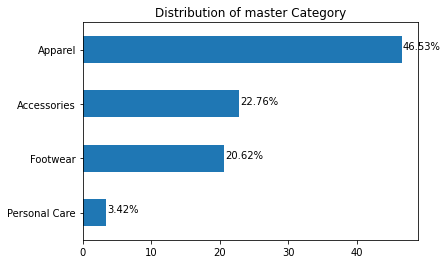

In [109]:
#continue with masterCategory
counts_masterCategory_clean=dfclean['masterCategory'].value_counts()/len(df)*100
ax=counts_masterCategory_clean.plot.barh()
ax.set_title('Distribution of master Category')
ax.invert_yaxis()
for i,value in enumerate(counts_masterCategory_clean):
    ax.annotate(str(round(value,2))+"%", xy=(value+0.15,i))
plt.savefig('distributionMasterCategory.png')
plt.show()

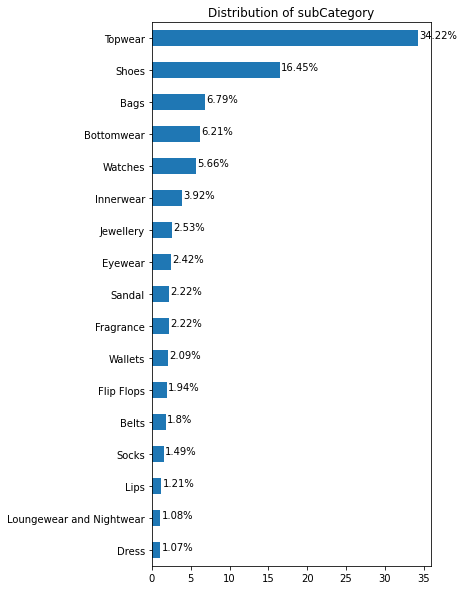

In [110]:
#continue with subCategory
counts_subCategory_clean=dfclean['subCategory'].value_counts()/len(df)*100
plt.figure(figsize=(5,10))
ax=counts_subCategory_clean.plot.barh()
ax.set_title('Distribution of subCategory')
ax.invert_yaxis()
for i,value in enumerate(counts_subCategory_clean):
    ax.annotate(str(round(value,2))+"%", xy=(value+0.15,i))
plt.savefig('distributionSubCategory.png')
plt.show()

### Image Processeing


In [20]:
#the image filename is the same id as in the dataset together with ".jpg"
filename0 = str(dfclean['id'][0])+".jpg"

In [21]:
#we can open the image by looking into the unzip folder
image = Image.open('fashion-products/myntradataset/images/'+filename0)

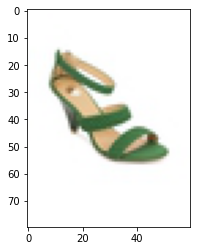

In [22]:
#we can show this first image
plt.imshow(image)
plt.show()

In [23]:
#this image corresponds to the 1st row in the dataset and we can look at the categories it belongs to
print("gender:",dfclean['gender'][0]," mastercategory:", dfclean['masterCategory'][0],
      " subcategory:",dfclean['subCategory'][0])

gender: Women  mastercategory: Footwear  subcategory: Shoes


In [24]:
#to process the image in the Neural network we will need to do the following process to each of them:
#covert to array
image_array = np.asarray(image)

In [25]:
#verify if it is in the correct shape, if not, transform, if not possible discart
image_array.shape

(80, 60, 3)

In [26]:
#scale the values between 0 and 1
image_array= image_array/255


In [27]:
#we will do this to all the pictures and add the pictures to the image list
#if there is any problem with a specific picture, the number will be added to the wrong ids list which will
# be removed from the dataset
images_list=[]
wrong_ids=[]
for i in range(len(dfclean)):
    filename = str(dfclean['id'][i])+".jpg"
    try:
        image = Image.open('fashion-products/myntradataset/images/'+filename)
        image_array = np.asarray(image)
        if image_array.shape!=(80,60,3):
            image.thumbnail((60,80))
            image_array=np.asarray(image)
        if image_array.shape!=(80,60,3):
            wrong_ids.append(dfclean['id'][i])
        else: 
            image_array= image_array/255
            images_list.append(image_array)
    except FileNotFoundError:
        wrong_ids.append(dfclean['id'][i])
        continue



In [28]:
#this is the number of items that we will need to discart from the dataset
len(wrong_ids)

131

In [29]:
# we will remove the items that its picture wasn't able to process
for i in range(len(dfclean)):
    if dfclean['id'][i] in wrong_ids:
        dfclean.drop(i, axis=0, inplace=True)
#reset the index
dfclean.index=range(len(dfclean))

In [30]:
#this is the number of items in the final dataset
len(dfclean)

13821

In [31]:
#we will convert the list of processed images into a single numpy array
image_dataset=np.vstack(images_list)

In [32]:
#check the shape of it
image_dataset.shape

(1105680, 60, 3)

In [33]:
# I need to convert it to 4d array where the first dimension represent the number of samples,
#the second and the third the dimensions of the picture
#the third represent the colour channels (rgb)
image_dataset=image_dataset.reshape(len(dfclean),80,60,3)

### Continue Preparing the dataset for Neural Network
#### One hot-encoding the classes within the categories

In [34]:
#trasnsform the genderlabels into one-hot encoding dataframe
gender_dummies=pd.get_dummies(dfclean['gender'])

In [35]:
#get the classes list of gender in order
gender_classes=gender_dummies.columns

In [36]:
#get only the values as a 2d tensor
gender_labels=gender_dummies.iloc[:,:].values
gender_labels

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [37]:
#get one hot-encoding tensor for the other categories
masterCategory_dummies=pd.get_dummies(dfclean['masterCategory'])
masterCategory_classes=masterCategory_dummies.columns
masterCategory_labels=masterCategory_dummies.iloc[:,:].values
subCategory_dummies=pd.get_dummies(dfclean['subCategory'])
subCatergory_classes=subCategory_dummies.columns
subCategory_labels=subCategory_dummies.iloc[:,:].values

In [38]:
#verify the shapes of the labels' tensors
print(gender_labels.shape)
print(masterCategory_labels.shape)
print(subCategory_labels.shape)

(13821, 5)
(13821, 4)
(13821, 17)


### Splitting the data into training, validation and test sets

In [39]:
#spliting 70%,15%, 15%
train_num=gender_labels.shape[0]*70//100
val_num=gender_labels.shape[0]*85//100

In [40]:
train_images=image_dataset[:train_num]
train_gender_labels=gender_labels[:train_num]
train_masterCategory_labels=masterCategory_labels[:train_num]
train_subCategory_labels=subCategory_labels[:train_num]
val_images=image_dataset[train_num:val_num]
val_gender_labels=gender_labels[train_num:val_num]
val_masterCategory_labels=masterCategory_labels[train_num:val_num]
val_subCategory_labels=subCategory_labels[train_num:val_num]
test_images=image_dataset[val_num:]
test_gender_labels=gender_labels[val_num:]
test_masterCategory_labels=masterCategory_labels[val_num:]
test_subCategory_labels=subCategory_labels[val_num:]


## 5. Develope a model that does better than the baseline

### Creation of a baseline model by creating a model using dense layer only.

In [41]:
#we need the number of classes for each classification for the last layer with the softmax activation
num_gender=gender_labels.shape[1]
num_masterCategory=masterCategory_labels.shape[1]
num_subCategory=subCategory_labels.shape[1]

In [42]:
# creating a basic Neural Network model with only fully connected layers
input_layer = Input(shape=(80,60,3))
x=layers.Flatten()(input_layer)
x=layers.Dense(100, activation='relu')(x)
x=layers.Dense(50, activation='relu')(x)
gender_prediction=layers.Dense(num_gender, activation='softmax', name='gender')(x)
masterCategory_prediction=layers.Dense(num_masterCategory, activation='softmax', name='masterCategory')(x)
subCategory_prediction=layers.Dense(num_subCategory, activation='softmax', name='subCategory')(x)

model = models.Model(input_layer, [gender_prediction, masterCategory_prediction, subCategory_prediction])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 60, 3)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 14400)        0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 100)          1440100     ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 50)           5050        ['dense[0][0]']                  
                                                                                              

In [43]:
model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                    'masterCategory': 'categorical_crossentropy',
                    'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])

In [44]:
#define an early stopping to simplify the learning
early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor = 'val_loss',
                mode = 'auto',
                min_delta = 0,
                patience = 2,
                verbose = 0, 
                restore_best_weights = True)

In [45]:
#run the baseline model
history=model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                'subCategory':train_subCategory_labels},
                  batch_size=128,
                  epochs=15,
                  callbacks=[early_stopping],
                  validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]), verbose=0)

In [46]:
total_BL_loss, _,_,_,BL_gender_acc, BL_masterCategory_acc, BL_subCategory_acc=model.evaluate(test_images,[test_gender_labels,test_masterCategory_labels,test_subCategory_labels])

65/65 [==============================] - 0s 7ms/step - loss: 1.9705 - gender_loss: 0.6974 - masterCategory_loss: 0.3165 - subCategory_loss: 0.9566 - gender_accuracy: 0.6924 - masterCategory_accuracy: 0.8689 - subCategory_accuracy: 0.6851


In [47]:
print('Baseline model accuracies')
print('gender classification: ',BL_gender_acc)
print('masterCategory classification',BL_masterCategory_acc)
print('subCategory classification', BL_subCategory_acc)

Baseline model accuracies
gender classification:  0.6923818588256836
masterCategory classification 0.868852436542511
subCategory classification 0.6851494908332825


In [48]:
print('average classification accuracy')
np.mean([BL_gender_acc,BL_masterCategory_acc, BL_subCategory_acc])


average classification accuracy


0.7487945954004923

The Baseline model with fully connected layers has an average accuracy of 74.9% for image classification, this is really good for a classifier which is not able to retain graphical patterns and assumes the object is always in the same position.

### Building a simple Convolutional Neural Network to beat the baseline model
A convolutional neural network model contains at least one convolutional layer.
We will create a basic convolutional layer model with a single convolutional layer, a maxpooling layer, a flatten layer, a single dense layer in addition to the output layers for classification.

In [49]:
# Creation of the basic convolutional layer
input_layer = Input(shape=(80,60,3))
x=layers.Conv2D(32, 3, activation='relu')(input_layer)
x=layers.MaxPooling2D(2,2)(x)
x=layers.Flatten()(x)
x=layers.Dense(50, activation='relu')(x)
gender_prediction=layers.Dense(num_gender, activation='softmax', name='gender')(x)
masterCategory_prediction=layers.Dense(num_masterCategory, activation='softmax', name='masterCategory')(x)
subCategory_prediction = layers.Dense(num_subCategory, activation='softmax', name='subCategory')(x)
model = models.Model(input_layer, [gender_prediction, masterCategory_prediction, subCategory_prediction])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 60, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 78, 58, 32)   896         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 39, 29, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 36192)        0           ['max_pooling2d[0][0]']          
                                                                                            

In [50]:
model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                    'masterCategory': 'categorical_crossentropy',
                    'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
history=model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                'subCategory':train_subCategory_labels},
                  batch_size=128,
                  epochs=15,
                  validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]), 
                  verbose=0)

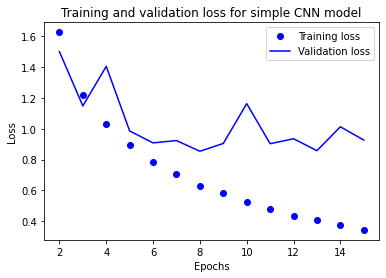

In [51]:
epochs_range=range(2,len(history.history['loss'])+1)
plt.plot(epochs_range, history.history['loss'][1:], 'bo', label='Training loss')
plt.plot(epochs_range, history.history['val_loss'][1:], 'b', label='Validation loss')
plt.title('Training and validation loss for simple CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

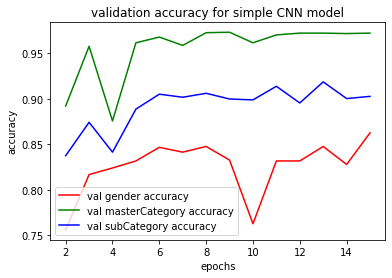

In [52]:
plt.plot(epochs_range,history.history['val_gender_accuracy'][1:], c='red',label='val gender accuracy')
plt.plot(epochs_range,history.history['val_masterCategory_accuracy'][1:], c='green', label='val masterCategory accuracy')
plt.plot(epochs_range,history.history['val_subCategory_accuracy'][1:], c='blue', label='val subCategory accuracy')
plt.title('validation accuracy for simple CNN model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [53]:
_,_,_,_,gender_accuracy_cnn, masterCategory_accuracy_cnn, subCategory_accuracy_cnn=model.evaluate(test_images,[test_gender_labels,test_masterCategory_labels,test_subCategory_labels])

65/65 [==============================] - 1s 10ms/step - loss: 0.8641 - gender_loss: 0.4466 - masterCategory_loss: 0.0810 - subCategory_loss: 0.3365 - gender_accuracy: 0.8664 - masterCategory_accuracy: 0.9744 - subCategory_accuracy: 0.9069


In [54]:
print('average classification accuracy')
np.mean([gender_accuracy_cnn, masterCategory_accuracy_cnn, subCategory_accuracy_cnn])

average classification accuracy


0.915943423906962

The simple CNN model beats significantly the baseline model reaching an average accuracy of 91.6%  for the multi-output classification tasks which is much higher than the 74.9% from the baseline model. This model is able to retain graphical patterns from the images, and does not assume that the object is in the same position for every image. We should continue working to see if we can improve the model and optimise it.

## 6. Scaling up: develop to a model that overfits
Convolutional Neural Networks models generally follow an architecture where we start with an image tensor which is composed of the 2 dimensions of the picture and the third dimension is the number of chanells which represent the primary colors (red, green and blue). By applying the different CNN layers in the network we reduce the size of the image while increasing the number of channels which represent the different kernel filters that are applied to the image or the previous input layer. Hence, we end up with a compressed small size "image", which has a high number of channels. 

Following this logic, we would like to explore different hyperparameters for the local receptive fields, the number of filters per layer, in addition to the number of nodes in the dense layer. As the number of filters for each layer will be different, we will define the hyperparameter "filters_amount" as "few" or "many" which will dictate the number of filters for each layer. Similarly, we will use the hyperparameter for the local receptive field as "small" or "large" taking in account that for the initial layers we can use larger patches than the ones in further up layers.

In [55]:
#Create a class trial where I am storing the results and functions to visualise the results
class Trial:
    def __init__(self, lrf_1and2_size, filters_amount,
                   dense_layer_nodes, history, dropout=0, batch_normalisation=0):
        self.lrf_1and2_size=lrf_1and2_size
        self.filters_amount=filters_amount
        self.dense_layers_nodes=dense_layer_nodes
        self.dropout=dropout
        self.history=history
        self.batch_normalisation=batch_normalisation
        self.MinValLoss=np.min(self.history.history['val_loss'])
        self.gender_val_acc, self.masterCategory_val_acc, self.subCategory_val_acc, self.AvgMaxValAccuracy=self.avg_max_val_accuracy()

    def avg_max_val_accuracy(self):
        min_val_epoch=np.argmin(self.history.history['val_loss'])
        gender_val_acc=self.history.history['val_gender_accuracy'][min_val_epoch]
        masterCategory_val_acc=self.history.history['val_masterCategory_accuracy'][min_val_epoch]
        subCategory_val_acc=self.history.history['val_subCategory_accuracy'][min_val_epoch]
        avg_acc=np.mean([gender_val_acc, masterCategory_val_acc, subCategory_val_acc])
        return gender_val_acc, masterCategory_val_acc, subCategory_val_acc, avg_acc

In [56]:
#create a function to build a CNN model given the specific hyperparameters
def build_model(filters_1st_layer, lrf_1st_layer, filters_2nd_layer, lrf_2nd_layer,
                filters_3rd_layer, nodes_dense_layer, dropout=0, batch_normalisation=0 ):
    input_layer = Input(shape=(80,60,3))
    if batch_normalisation==1:
        x=layers.Conv2D(filters_1st_layer, lrf_1st_layer, use_bias=False)(input_layer)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
    else:
        x=layers.Conv2D(filters_1st_layer, lrf_1st_layer, activation='relu')(input_layer)
    x = layers.MaxPooling2D(2,2)(x)
    if  batch_normalisation==2:
        x=layers.Conv2D(filters_2nd_layer, lrf_2nd_layer, use_bias=False)(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
    else:
        x=layers.Conv2D(filters_2nd_layer, lrf_2nd_layer, activation='relu')(x)
    x=layers.MaxPooling2D(2,2)(x)
    if  batch_normalisation==3:
        x=layers.Conv2D(filters_3rd_layer, 3, use_bias=False)(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
    else:
        x=layers.Conv2D(filters_3rd_layer, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    if dropout>0:
        x=layers.Dropout(dropout)(x)
    if  batch_normalisation==4:
        x=layers.Dense(nodes_dense_layer)(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
    else:
        x=layers.Dense(nodes_dense_layer, activation='relu')(x)
    gender_prediction=layers.Dense(num_gender, activation='softmax', name='gender')(x)
    masterCategory_prediction=layers.Dense(num_masterCategory,activation='softmax', name='masterCategory')(x)
    subCategory_prediction = layers.Dense(num_subCategory, activation='softmax', name='subCategory')(x)

    model = models.Model(input_layer, [gender_prediction, masterCategory_prediction, subCategory_prediction])
    return model

In [57]:
#I scaled up the model to a model that overfits with the highest values hyperparameters
big_model=build_model(32, 7, 64, 5, 96, 100 )
big_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 60, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 74, 54, 32)   4736        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 37, 27, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 33, 23, 64)   51264       ['max_pooling2d_1[0][0]']        
                                                                                            

In [58]:
#compile and train the model
big_model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                    'masterCategory': 'categorical_crossentropy',
                    'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
history=big_model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                'subCategory':train_subCategory_labels},
                  batch_size=128,
                  epochs=30,
                  validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]),
                  verbose=0)
big_model_trial=Trial(lrf_1and2_size='large', filters_amount='many', dense_layer_nodes=100, history=history)

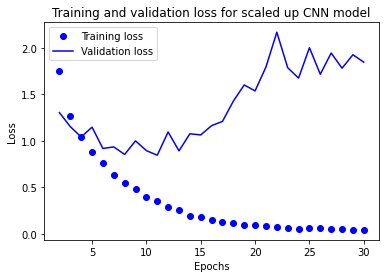

In [59]:
epochs_range=range(2,len(history.history['loss'])+1)
plt.plot(epochs_range, history.history['loss'][1:], 'bo', label='Training loss')
plt.plot(epochs_range, history.history['val_loss'][1:], 'b', label='Validation loss')
plt.title('Training and validation loss for scaled up CNN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

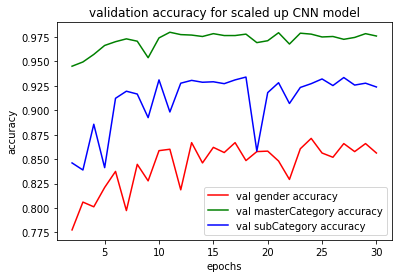

In [60]:
plt.plot(epochs_range,history.history['val_gender_accuracy'][1:], c='red',label='val gender accuracy')
plt.plot(epochs_range,history.history['val_masterCategory_accuracy'][1:], c='green', label='val masterCategory accuracy')
plt.plot(epochs_range,history.history['val_subCategory_accuracy'][1:], c='blue', label='val subCategory accuracy')
plt.title('validation accuracy for scaled up CNN model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The scaled up model clearly overfits the training data as we can see from the graph "Training and Validation loss for the scaled up CNN model". Moreover, comparing the validation accuracy graphs between the simple model and the big model, the latest is cappable of getting to higher accuracies, even though they drop when overfitting.

We should continue working with the big model architecture, where we apply 3 convolutional layers while tunning the hyperparameters.

## 7. Tune hyperparameter and add regularizer

### Tunning hyperparameters for a standard model architecture

In [66]:
#I carry out an experiment changing 3 hyperparameters, the patch size, the number of filters per layer
#and the number of nodes in the dense layer. 
lrf_size={'small':[5,3],'large':[7,5]} #the 1st number in the lists goes to the 1st layer, the 2nd to the 2nd and so on..
filters_amount={'few':[16,32,64],'many':[32,64,96]}
nodes_dense_layer_values=[50,100]
trials=[]
for size in lrf_size:
    for filters in filters_amount:
        for nodes_dense_layer in nodes_dense_layer_values:
            model=build_model(filters_amount[filters][0], lrf_size[size][0],filters_amount[filters][1],lrf_size[size][1],
                            filters_amount[filters][2],nodes_dense_layer )
            model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                                                     'masterCategory': 'categorical_crossentropy',
                                                     'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
            history=model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                            'subCategory':train_subCategory_labels},
                              batch_size=128,
                              epochs=20,
                              validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]),
                              verbose=0)
            trial=Trial(size, filters, nodes_dense_layer, history=history)  #create an instant of a trial for each experiment
            trials.append(trial)#and stored them in a list of trials


In [67]:
#store the results in a dictionary
results={'lrf_size_1and2':[],'filters_amount':[],'dense_layer_nodes':[],'min_val_loss':[],'avg_max_val_acc':[],
         'gender_val_acc':[], 'masterCategory_val_acc':[],'subCategory_val_acc':[]}
for trial_ in trials:
    results['lrf_size_1and2'].append(trial_.lrf_1and2_size)
    results['filters_amount'].append(trial_.filters_amount)
    results['dense_layer_nodes'].append(trial_.dense_layers_nodes)
    results['min_val_loss'].append(trial_.MinValLoss)
    results['avg_max_val_acc'].append(trial_.AvgMaxValAccuracy)
    results['gender_val_acc'].append(trial_.gender_val_acc)
    results['masterCategory_val_acc'].append(trial_.masterCategory_val_acc)
    results['subCategory_val_acc'].append(trial_.subCategory_val_acc)


In [68]:
#tabulate the results in a dataframe
resultsdf=pd.DataFrame(results)
resultsdf

,lrf_size_1and2,filters_amount,dense_layer_nodes,min_val_loss,avg_max_val_acc,gender_val_acc,masterCategory_val_acc,subCategory_val_acc
0,small,few,50,0.765812,0.923300,0.861553,0.978292,0.930053
1,small,few,100,0.714545,0.928445,0.870236,0.983116,0.931983
2,small,many,50,0.794507,0.923300,0.869272,0.980222,0.920405
3,small,many,100,0.803772,0.923943,0.864930,0.978775,0.928123
4,large,few,50,0.830469,0.915099,0.849976,0.976363,0.918958
5,large,few,100,0.803091,0.914134,0.838881,0.977328,0.926194
6,large,many,50,0.824883,0.911561,0.855282,0.964785,0.914617
7,large,many,100,0.805890,0.918636,0.850458,0.975880,0.929571


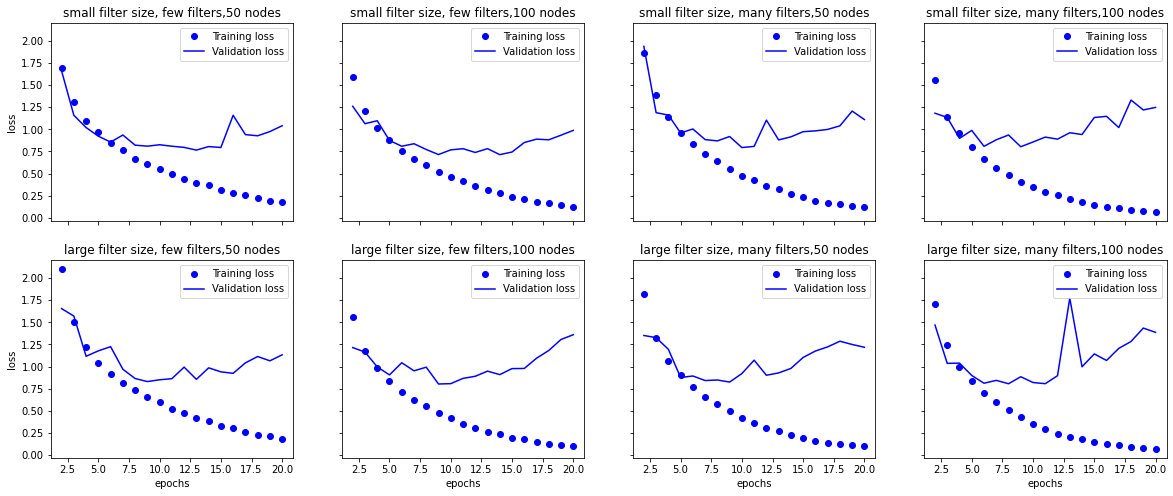

In [69]:
#plot the results
from IPython.core.pylabtools import figsize
fig, axs=plt.subplots(2,4, sharey=True, figsize=(20,8))
for i,trial_ in enumerate(trials):
    epochs_range=range(2,len(trial_.history.history['loss'])+1)
    axs[i//4][i%4].plot(epochs_range, trial_.history.history['loss'][1:], 'bo', label='Training loss')
    axs[i//4][i%4].plot(epochs_range, trial_.history.history['val_loss'][1:], 'b', label='Validation loss')
    axs[i//4][i%4].set_title('{a} filter size, {b} filters,{c} nodes'.format(a=trial_.lrf_1and2_size,
                                                                             b=trial_.filters_amount,
                                                                             c=trial_.dense_layers_nodes))
    axs[i//4][i%4].set_xlabel('epochs')
    axs[i//4][i%4].set_ylabel('loss')
    axs[i//4][i%4].legend()
for ax in axs.flat:
    ax.label_outer()
plt.savefig('experimentalResults.png', bbox_inches='tight')

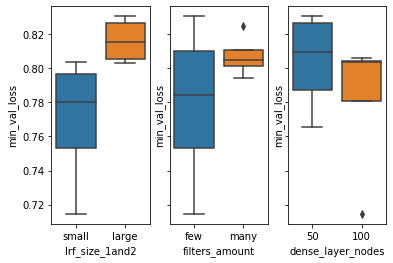

In [70]:
fig, (ax1,ax2, ax3)= plt.subplots(1,3, sharey=True)
g1=sns.boxplot(x='lrf_size_1and2',y='min_val_loss', data=resultsdf, ax=ax1)
g2=sns.boxplot(x='filters_amount',y='min_val_loss', data=resultsdf, ax=ax2)
g3=sns.boxplot(x='dense_layer_nodes',y='min_val_loss', data=resultsdf, ax=ax3)
plt.savefig('boxplotloss.png', bbox_inches='tight')
plt.show()

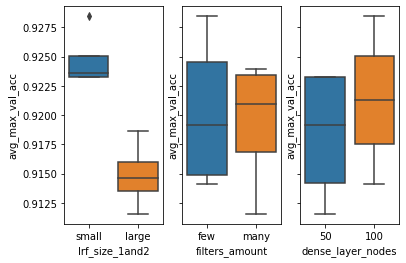

In [71]:
fig, (ax1,ax2, ax3)= plt.subplots(1,3, sharey=True)
g1=sns.boxplot(x='lrf_size_1and2',y='avg_max_val_acc', data=resultsdf, ax=ax1)
g2=sns.boxplot(x='filters_amount',y='avg_max_val_acc', data=resultsdf, ax=ax2)
g3=sns.boxplot(x='dense_layer_nodes',y='avg_max_val_acc', data=resultsdf, ax=ax3)
plt.savefig('boxplotacc.png', bbox_inches='tight')
plt.show()

In [72]:
best_loss_trial=resultsdf['min_val_loss'].argmin()

In [73]:
print(best_loss_trial)

1


From the latest experiments, we can understand that a small local receptive field gives higher validation accuracies and lower validation losses for this particular computer vision task. On the other hand, there is no optimal amount of filters nor optimal number of nodes in the dense layer as we can see that there is no significant difference on the distributions of the average maximum validation accuracy for the amount of filters or dense layer nodes. The experiments with the best results are the ones which combine a high number on one hyperparameter with a low number on the second one, together with a small local receptive field size.

The experiment which reached the minimum validation loss is the experiment with small local receptive fields, fewer filters per layer and 100 nodes in the dense layer so we will continue working with these hyperparameters for the next step. 

### Adding Batch Normalisation

In this step we will add batch normalisation within the training. We have scaled the values before training, however the output values that change after each layer transformation and can create bias. The batch normalisation could prevent the bias and help with the learning. We will start by adding one batch normalisation layer at different stages of the model for each experiment.
When the Batch normalisation value is 1, the batch normalisation layer will be added after the 1st conv2d layer, if it is 2, it will be added after the 2nd conv2d layer and the same for 3. If the Batch normalisation value is 4, the batch normalisation will be added after the dense layer.

In [74]:
#run the batch normalisation experiments
BN_trials=[]  #we will save the trials in a list
BN_trials.append(trials[best_loss_trial]) # we will save the latest best trial so we can compare with the next ones
BN_values=[1,2,3,4]
lrf_size_1=trials[best_loss_trial].lrf_1and2_size #the best hyperparameters will be used in the following experiments
filters_amount_1=trials[best_loss_trial].filters_amount
dense_layer_nodes_1=trials[best_loss_trial].dense_layers_nodes
for value in BN_values:
    model=build_model(filters_amount[filters_amount_1][0], lrf_size[lrf_size_1][0],
                      filters_amount[filters_amount_1][1], lrf_size[lrf_size_1][1],
                      filters_amount[filters_amount_1][2],dense_layer_nodes_1, batch_normalisation=value)
    model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                                             'masterCategory': 'categorical_crossentropy',
                                             'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
    history=model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                    'subCategory':train_subCategory_labels},
                      batch_size=128,
                      epochs=20,
                      validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]),
                      verbose=0)
    trial=Trial(lrf_size_1, filters_amount_1, dense_layer_nodes_1,batch_normalisation=value, history=history)
    BN_trials.append(trial)

In [75]:
#tabulate the latest results
results={'lrf_size_1and2':[],'filters_amount':[],'dense_layer_nodes':[],'batch_normalisation':[],
         'min_val_loss':[],'avg_max_val_acc':[],'gender_val_acc':[], 'masterCategory_val_acc':[],'subCategory_val_acc':[]}
for trial_ in BN_trials:
    results['lrf_size_1and2'].append(trial_.lrf_1and2_size)
    results['filters_amount'].append(trial_.filters_amount)
    results['dense_layer_nodes'].append(trial_.dense_layers_nodes)
    results['batch_normalisation'].append(trial_.batch_normalisation)
    results['min_val_loss'].append(trial_.MinValLoss)
    results['avg_max_val_acc'].append(trial_.AvgMaxValAccuracy)
    results['gender_val_acc'].append(trial_.gender_val_acc)
    results['masterCategory_val_acc'].append(trial_.masterCategory_val_acc)
    results['subCategory_val_acc'].append(trial_.subCategory_val_acc)

resultsdfnew=pd.DataFrame(results)
resultsdfnew

,lrf_size_1and2,filters_amount,dense_layer_nodes,batch_normalisation,min_val_loss,avg_max_val_acc,gender_val_acc,masterCategory_val_acc,subCategory_val_acc
0,small,few,100,0,0.714545,0.928445,0.870236,0.983116,0.931983
1,small,few,100,1,0.721791,0.929731,0.870236,0.984563,0.934395
2,small,few,100,2,0.773759,0.920244,0.851423,0.981669,0.927641
3,small,few,100,3,0.855806,0.909632,0.837916,0.970092,0.920888
4,small,few,100,4,0.945540,0.906416,0.845634,0.969127,0.904486


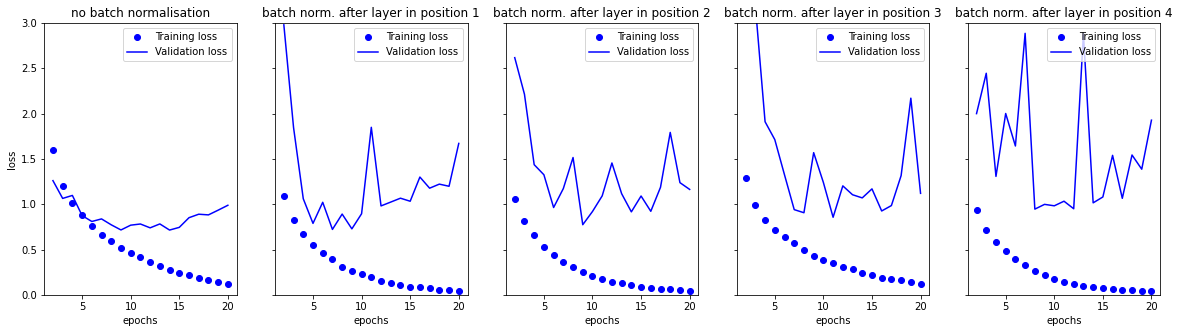

In [76]:
#plot the latest results
fig, axs=plt.subplots(1,5, sharey=True, sharex=True, figsize=(20,5))
for i,trial_ in enumerate(BN_trials):
    epochs_range=range(2,len(trial_.history.history['loss'])+1)
    axs[i].plot(epochs_range, trial_.history.history['loss'][1:], 'bo', label='Training loss')
    axs[i].plot(epochs_range, trial_.history.history['val_loss'][1:], 'b', label='Validation loss')
    if i==0:
        axs[i].set_title('no batch normalisation')
    else:
        axs[i].set_title('batch norm. after layer in position {}'.format(trial_.batch_normalisation))
    axs[i].set_ylabel('loss')
    axs[i].set_xlabel('epochs')
    axs[i].set_ylim(0,3)
    axs[i].legend()
for ax in axs.flat:
    ax.label_outer()
plt.savefig('BNresults.png', bbox_inches='tight')
plt.show()

In [77]:
best_loss_BN_trial=resultsdfnew['min_val_loss'].argmin()

In [78]:
best_loss_BN_trial

0

The Batch normalisation didn't improve the model, we can see that the validation loss vs epochs plots for the trials with batch normalisation show much more oscilation without reducing the validation loss. Hence the best trial is the one obtained in the previous step without batch normalisation

### Adding Dropout regulariser

In the next step, we will add a dropout layer before the dense layer after we flatten the last conv2d output. For this experiment, we will try using three values of dropout rate and we will compare them to the original model without dropout.

In addition, we will increase the number of epochs, as the dropout generally slows the learning down but it may reach lower validation losses and higher validation accuracies.

In [79]:
best_BNorm=BN_trials[best_loss_BN_trial].batch_normalisation #store the best batch normalisation value
DO_trials=[]  #we will save the trials in a list
DO_trials.append(BN_trials[best_loss_BN_trial]) #we will add the best model from the latest experiment
DO_values=[0.3,0.4,0.5] #we try the different dropout values
for value in DO_values:
    model=build_model(filters_amount[filters_amount_1][0], lrf_size[lrf_size_1][0],
                      filters_amount[filters_amount_1][1], lrf_size[lrf_size_1][1],
                      filters_amount[filters_amount_1][2],dense_layer_nodes_1, batch_normalisation=best_BNorm, dropout=value)
    model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                                             'masterCategory': 'categorical_crossentropy',
                                             'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
    history=model.fit(train_images,{'gender':train_gender_labels,'masterCategory':train_masterCategory_labels,
                                    'subCategory':train_subCategory_labels},
                      batch_size=128,
                      epochs=30,
                      validation_data=(val_images,[val_gender_labels,val_masterCategory_labels,val_subCategory_labels]),
                      verbose=0)
    trial=Trial(lrf_size_1, filters_amount_1,dense_layer_nodes_1,dropout=value,batch_normalisation=best_BNorm, history=history)
    DO_trials.append(trial) #we save the results


In [80]:
#tabulate the latest results
results={'lrf_size_1and2':[],'filters_amount':[],'dense_layer_nodes':[],'batch_normalisation':[],'dropout':[],
         'min_val_loss':[],'avg_max_val_acc':[],'gender_val_acc':[], 'masterCategory_val_acc':[],'subCategory_val_acc':[]}
for trial_ in DO_trials:
    results['lrf_size_1and2'].append(trial_.lrf_1and2_size)
    results['filters_amount'].append(trial_.filters_amount)
    results['dense_layer_nodes'].append(trial_.dense_layers_nodes)
    results['batch_normalisation'].append(trial_.batch_normalisation)
    results['dropout'].append(trial_.dropout)
    results['min_val_loss'].append(trial_.MinValLoss)
    results['avg_max_val_acc'].append(trial_.AvgMaxValAccuracy)
    results['gender_val_acc'].append(trial_.gender_val_acc)
    results['masterCategory_val_acc'].append(trial_.masterCategory_val_acc)
    results['subCategory_val_acc'].append(trial_.subCategory_val_acc)

resultsdfnew=pd.DataFrame(results)
resultsdfnew


,lrf_size_1and2,filters_amount,dense_layer_nodes,batch_normalisation,dropout,min_val_loss,avg_max_val_acc,gender_val_acc,masterCategory_val_acc,subCategory_val_acc
0,small,few,100,0,0.0,0.714545,0.928445,0.870236,0.983116,0.931983
1,small,few,100,0,0.3,0.674966,0.929088,0.870236,0.984081,0.932947
2,small,few,100,0,0.4,0.668084,0.928767,0.862036,0.988905,0.935359
3,small,few,100,0,0.5,0.629902,0.932626,0.876990,0.986011,0.934877


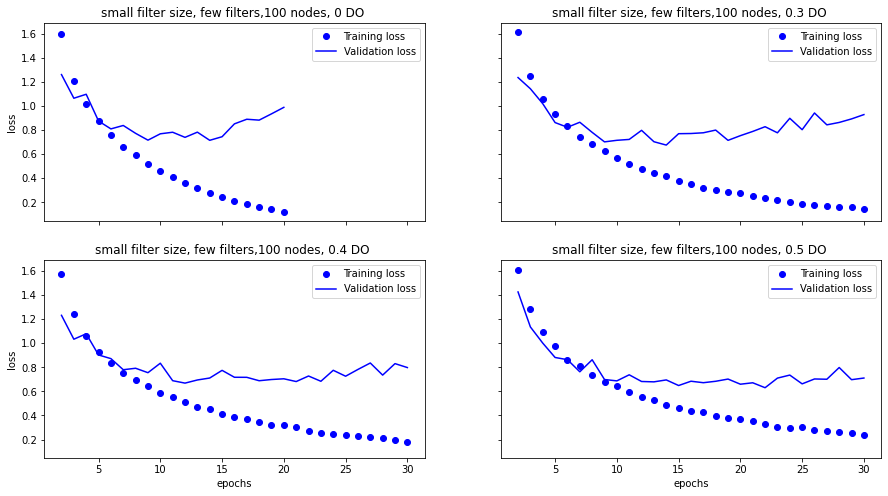

In [81]:
#plot the results
fig, axs=plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,8))
for i,trial_ in enumerate(DO_trials):
    epochs_range=range(2,len(trial_.history.history['loss'])+1)
    axs[i//2][i%2].plot(epochs_range, trial_.history.history['loss'][1:], 'bo', label='Training loss')
    axs[i//2][i%2].plot(epochs_range, trial_.history.history['val_loss'][1:], 'b', label='Validation loss')
    axs[i//2][i%2].set_title('{a} filter size, {b} filters,{c} nodes, {d} DO '.format(a=trial_.lrf_1and2_size,
                                                                                      b=trial_.filters_amount,
                                                                                      c=trial_.dense_layers_nodes,
                                                                                      d=trial_.dropout))
    axs[i//2][i%2].set_ylabel('loss')
    axs[i//2][i%2].set_xlabel('epochs')
    axs[i//2][i%2].legend()
for ax in axs.flat:
    ax.label_outer()
plt.savefig('DOresults.png', bbox_inches='tight')
plt.show()


In [82]:
best_loss_DO_trial=resultsdfnew['min_val_loss'].argmin()

In [83]:
best_loss_DO_trial

3

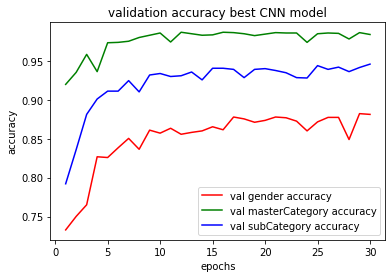

In [84]:
epochs_range=range(1,len(DO_trials[1].history.history['loss'])+1)
plt.plot(epochs_range,DO_trials[best_loss_DO_trial].history.history['val_gender_accuracy'], c='red',label='val gender accuracy')
plt.plot(epochs_range,DO_trials[best_loss_DO_trial].history.history['val_masterCategory_accuracy'],
         c='green', label='val masterCategory accuracy')
plt.plot(epochs_range,DO_trials[best_loss_DO_trial].history.history['val_subCategory_accuracy'],
         c='blue', label='val subCategory accuracy')
plt.title('validation accuracy best CNN model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('ValAccBestModel.png', bbox_inches='tight')
plt.show()




The best dropout trial is the one which applies 0.5 dropout, which means that for every epoch 50% of the input data to the dense layer is masked and forces the nodes to "learn" more from the data while avoiding overfitting which could be caused by coordination between many nodes in the same layer. The trial with the highest dropout rate achieved the lowest minimum validation loss and the maximum average validation accuracy. Moreover, we can see from the results table that the minimum validation loss decreases with the Dropout rate. In addition, we can see that the validation accuracies graph show higher values than the ones for the big CNN model and the simple CNN model.

Hence we will continue working with this trial. In the next step, we need to find the optimal number of epochs by looking at the epoch where the minimum validation loss ocurrs.

In [85]:
#finding the optimised number of epochs, we add 1 because it python data structure starts counting from 0
optimised_epochs=np.argmin(DO_trials[best_loss_DO_trial].history.history['val_loss'])+1

In [86]:
optimised_epochs

22

### Training the final model

Before training the final model, we need to join the training and validation sets into a final training set

In [87]:
#concatenate the training and validation images and labels
final_train_images=np.concatenate((train_images, val_images))
final_train_gender_labels=np.concatenate((train_gender_labels, val_gender_labels))
final_train_masterCategory_labels=np.concatenate((train_masterCategory_labels,val_masterCategory_labels))
final_train_subCategory_labels=np.concatenate((train_subCategory_labels, val_subCategory_labels))

In [88]:
#train the best model
best_dropout=DO_trials[best_loss_DO_trial].dropout
best_model=build_model(filters_amount[filters_amount_1][0], lrf_size[lrf_size_1][0],filters_amount[filters_amount_1][1],
                       lrf_size[lrf_size_1][1],filters_amount[filters_amount_1][2],dense_layer_nodes_1,
                       batch_normalisation=best_BNorm, dropout=best_dropout)
best_model.compile(optimizer='rmsprop', loss={'gender': 'categorical_crossentropy',
                                              'masterCategory': 'categorical_crossentropy',
                                              'subCategory': 'categorical_crossentropy'}, metrics=['accuracy'])
history=best_model.fit(final_train_images,{'gender':final_train_gender_labels,
                                           'masterCategory':final_train_masterCategory_labels,
                                           'subCategory':final_train_subCategory_labels},
                       batch_size=128,
                       epochs=optimised_epochs,
                       verbose=0)


# Final Results

In [89]:
#evaluate the model
# as it is a multi-output classification, there are 7 variables, the average total loss
#the 3 losses for each category and 3 accuracies, 1 for each category
total_final_loss,_,_,_,final_gender_acc,final_masterCategory_acc,final_subCategory_acc=best_model.evaluate(test_images,
                                                                                                           [test_gender_labels,
                                                                                                            test_masterCategory_labels,
                                                                                                            test_subCategory_labels])

65/65 [==============================] - 1s 15ms/step - loss: 0.5880 - gender_loss: 0.3347 - masterCategory_loss: 0.0606 - subCategory_loss: 0.1926 - gender_accuracy: 0.8939 - masterCategory_accuracy: 0.9831 - subCategory_accuracy: 0.9470


### Accuracy for each classification task

* Gender Classification accuracy

In [90]:
final_gender_acc

0.8939247727394104

* MasterCategory Classification accuracy

In [91]:
final_masterCategory_acc

0.9831243753433228

* SubCategory Classification accuracy

In [92]:
final_subCategory_acc

0.9469624161720276

* Average Accuracy

In [93]:
final_avg_accuracy=np.mean([final_gender_acc,final_masterCategory_acc,final_subCategory_acc])
print('the final average accuracy: ', final_avg_accuracy)


the final average accuracy:  0.9413371880849203




To understand better the model performance, we will plot confusion matrices. For this task, we need to predict the classes for each category given the test images.

### Confusion matrices

In [94]:
#predict the labels for each category
y_pred_gender, y_pred_masterCategory, y_pred_subCategory=best_model.predict(test_images)

In [95]:
#get a single value from the one-hot encoding for the predicted values
pred_gender=np.argmax(y_pred_gender, axis=1)

In [96]:
#do the same for the original labels
t_gender_labels=np.argmax(test_gender_labels, axis=1)

In [97]:
#generate a confusion matrix
matrix_gender=tf.math.confusion_matrix(t_gender_labels, pred_gender)

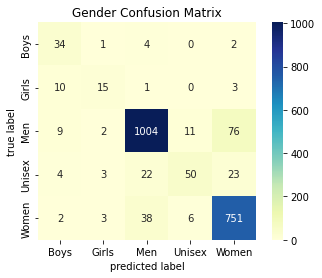

In [98]:
#plot the confusion matrix
sns.heatmap(matrix_gender, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=gender_classes, yticklabels=gender_classes)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('Gender Confusion Matrix')
plt.savefig('genderCM.png', bbox_inches='tight')
plt.show()

In [99]:
#get a single value from the one-hot encoding for the predicted values
pred_masterCategory=np.argmax(y_pred_masterCategory, axis=1)
t_masterCategory_labels=np.argmax(test_masterCategory_labels, axis=1)

In [100]:
#create the matrix
matrix_master=tf.math.confusion_matrix(t_masterCategory_labels, pred_masterCategory)

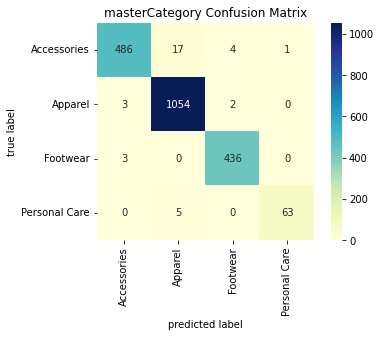

In [101]:
#plot it
sns.heatmap(matrix_master, square=True, annot=True, fmt='d', cbar=True,  cmap="YlGnBu",
            xticklabels=masterCategory_classes, yticklabels=masterCategory_classes)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('masterCategory Confusion Matrix')
plt.savefig('masterCatCM.png', bbox_inches='tight')
plt.show()

In [102]:
#get a single value from the one-hot encoding for the predicted values
pred_subCategory=np.argmax(y_pred_subCategory, axis=1)
t_subCategory=np.argmax(test_subCategory_labels, axis=1)

In [103]:
#create a matrix
matrix_sub=tf.math.confusion_matrix(t_subCategory, pred_subCategory)

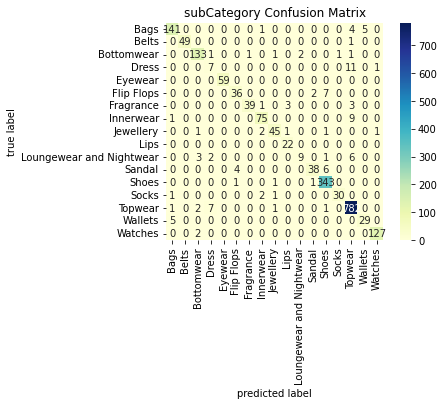

In [104]:
#plot it
sns.heatmap(matrix_sub, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=subCatergory_classes, yticklabels=subCatergory_classes)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.title('subCategory Confusion Matrix')
plt.savefig('subCatCM.png', bbox_inches='tight')
plt.show()

### Ploting test images examples

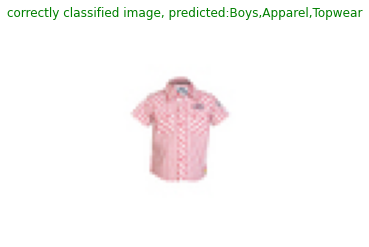

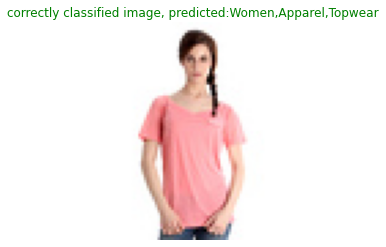

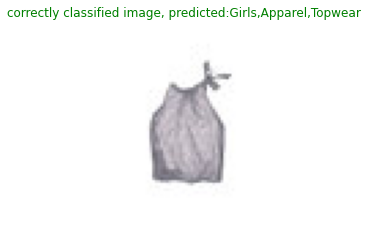

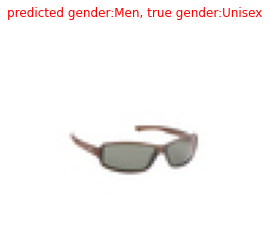

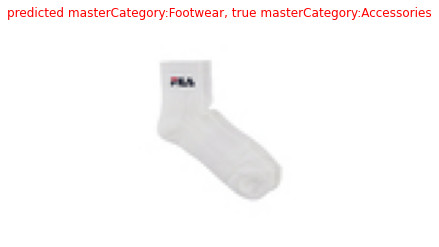

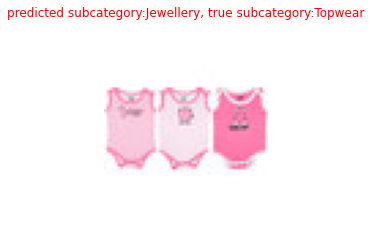

<Figure size 432x288 with 0 Axes>

In [107]:
#plot examples of correctly and incorreclty classified images
correct=0
incorrect_gender=0
incorrect_masterCategory=0
incorrect_subCategory=0
for i in range(len(pred_subCategory)):
    if correct<3:
        if pred_gender[i]==t_gender_labels[i] and pred_masterCategory[i]==t_masterCategory_labels[i] and pred_subCategory[i]==t_subCategory[i]:
            img_id=dfclean['id'][val_num+i]
            filename=str(img_id)+".jpg"
            image = Image.open('fashion-products/myntradataset/images/'+filename)
            plt.imshow(image)
            plt.axis('off')
            plt.title('correctly classified image, predicted:{a},{b},{c}'.format(a=gender_classes[pred_gender[i]],
                                                                                 b=masterCategory_classes[pred_masterCategory[i]],
                                                                                 c=subCatergory_classes[pred_subCategory[i]]),
                      fontdict={'color':'green'})
            plt.show()
            plt.savefig('correct{}.png'.format(i), bbox_inches='tight')
            correct+=1
            continue
    if incorrect_gender==0:
        if pred_gender[i]!=t_gender_labels[i]:
            img_id=dfclean['id'][val_num+i]
            filename=str(img_id)+".jpg"
            image = Image.open('fashion-products/myntradataset/images/'+filename)
            plt.imshow(image)
            plt.axis('off')
            plt.title('predicted gender:{a}, true gender:{b}'.format(a=gender_classes[pred_gender[i]],
                                                                     b=gender_classes[t_gender_labels[i]]),
                      fontdict={'color':'red'})
            plt.show()
            plt.savefig('incorrectgender.png', bbox_inches='tight')
            incorrect_gender=1
            continue
    if incorrect_masterCategory==0:
        if pred_masterCategory[i]!=t_masterCategory_labels[i]:
            img_id=dfclean['id'][val_num+i]
            filename=str(img_id)+".jpg"
            image = Image.open('fashion-products/myntradataset/images/'+filename)
            plt.imshow(image)
            plt.axis('off')
            plt.title('predicted masterCategory:{a}, true masterCategory:{b}'.format(a=masterCategory_classes[pred_masterCategory[i]],
                                                                                     b=masterCategory_classes[t_masterCategory_labels[i]]),
                      fontdict={'color':'red'})
            plt.show()
            plt.savefig('incorrectmaster.png', bbox_inches='tight')
            incorrect_masterCategory=1
            continue
    if incorrect_subCategory==0:
        if pred_subCategory[i]!=t_subCategory[i]:
            img_id=dfclean['id'][val_num+i]
            filename=str(img_id)+".jpg"
            image = Image.open('fashion-products/myntradataset/images/'+filename)
            plt.imshow(image)
            plt.axis('off')
            plt.title('predicted subcategory:{a}, true subcategory:{b}'.format(a=subCatergory_classes[pred_subCategory[i]],
                                                                               b=subCatergory_classes[t_subCategory[i]]),
                      fontdict={'color':'red'})
            plt.show()
            plt.savefig('incorrect.png', bbox_inches='tight')
            incorrect_subCategory=1
    if incorrect_subCategory==1 and incorrect_masterCategory==1 and incorrect_gender==1 and correct==3:
        break

# Conclusions 
The average final model accuracy is 94.1%. This a is a really good success, given the initial baseline model accuracy of 74.9% and the simple CNN model accuracy of 91.6%. Extending the model with more Cov2d layers, optimising the hyperparameters while adding dropout regularisation helped reduce the loss and improve the final accuracy. 

From the gender's confusion matrix, we can see that the model predicted high percentages of womens, mens and boys articles however, it wasn't as good at prediting unisex articles or girls ones.
From the masterCategory and subCategory confusion matrix, we can see that the model has done a great job classifying the fashion articles, as we can see higher numbers in the diagonal with many 0s and low numbers around them.
Even thought there were less-represented classes, they were generally classified correctly with high accuracy. 

The example images above show again how successfull was the model on image classification, especially for difficult task such as classifying the gender of a boys and girls apparel which each of them represented less than 2% of the dataset. 
On the other hand, the model failed to classified a pair of sunglasses as unisex while incorrectly classifying them as mens. This taks is quite tricky and we have seen from the confusion matrix that this is the area where the model failed the most, but the truth is that any other human could fail in this classification task. There could be many options to improve this, first we could check that the eyeweare articles have equally instances of all the 3 genders to avoid bias, or the other option is to classify all the eyewear as unisex. 
Surprisingly, the model has predicted a sock as a footwear, however this was considered a mistake by the model because the sock was incorrectly labeled as accessory by the dataset creator. This demonstrates how a model could be better at detecting human mistakes. 
Regarding the last article that the model has confused, the baby clothes, it could be easily seen that the fact that there are 3 peices of apparel in the picture, instead of one, the model has confused them with jewlery. This demonstrates the need to have pre-requirements when loading an article image where only one piece should be shot.

As a final conclusion, given all the final results, we could accept the initial stated hypothesis:
* The gender and article type (both for a masterCategory and subCategory) could be predicted from the article image.

This model could be implemented as part of the dataset maintenance of an e-commerce platform where the sellers can upload the picture of the article they want to sell and the model would classify the article by the gender, article masterCategory and subCategory.

# References

1. Aggarwal, P., 2019. Fashion Product Images (Small). [online] Kaggle.com. Available at: <https://www.kaggle.com/paramaggarwal/fashion-product-images-small> [Accessed 23 February 2022].